**Read this Paper:** https://arxiv.org/pdf/1708.02182v1.pdf which achieved 93% accuracy. 

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    ax[0].plot(history.history["loss"], label="loss")
    ax[0].plot(history.history["val_loss"], label="val_loss")
    ax[0].legend()
    
    ax[1].plot(history.history["acc"], label="acc")
    ax[1].plot(history.history["val_acc"], label="val_acc")
    ax[1].legend()
    return None

In [109]:
INP_DIR = "data/data_"
DOWNLOAD_DIR = "data/dowload"

In [4]:
reviews_train = pd.read_csv(os.path.join(INP_DIR, "reviews_train.csv"))
reviews_val = pd.read_csv(os.path.join(INP_DIR, "reviews_val.csv"))
reviews_test = pd.read_csv(os.path.join(INP_DIR, "reviews_test.csv"))

y_train = reviews_train["sentiment"].values
y_val = reviews_val["sentiment"].values
y_test = reviews_test["sentiment"].values

reviews_train.shape, reviews_val.shape, reviews_test.shape

((32000, 2), (8000, 2), (10000, 2))

# Word embedding + a hidden dense layer

In [5]:
MAX_WORDS_PER_DOC = 200
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 200), (8000, 200), (10000, 200))

In [6]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 1e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2000100   
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               10000500  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 12,001,101
Trainable params: 12,001,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
500/500 [==============================] - 8s 15ms/step - loss: 0.5794 - acc: 0.6880 - val_loss: 0.3793 - val_acc: 0.8510
Epoch 2/100
500/500 [==============================] - 7s 15ms/step - loss: 0.2970 - acc: 0.8813 - val_

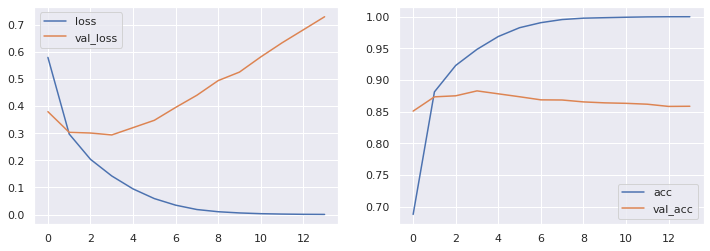

In [7]:
plot_history(history)

In [8]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8763


# Word embedding + LSTM layers

In [16]:
MAX_WORDS_PER_DOC = 200
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 200), (8000, 200), (10000, 200))

In [17]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(100))

model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 1e-3
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 200, 100)          80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 2,241,401
Trainable params: 2,241,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
500/500 [==============================] - 27s 54ms/step - loss: 0.6565 - acc: 0.5796 - val_los

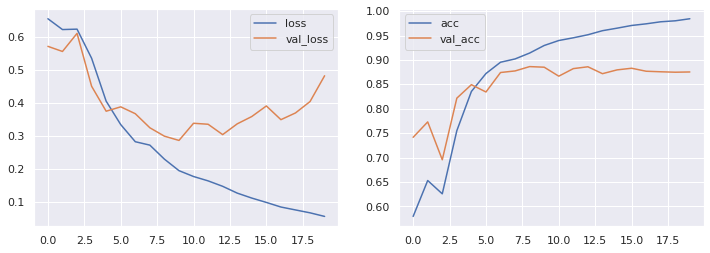

In [18]:
plot_history(history)

In [19]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8818


The last LSTM layer returns the whole sequence and is flatten before connected to the output layer. 

In [20]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.LSTM(100, return_sequences=True))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 1e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 200, 100)          80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20001     
Total params: 2,261,301
Trainable params: 2,261,301
Non-trainable params: 0
______________________________________________

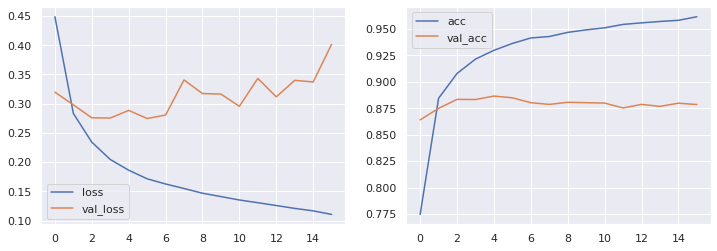

In [21]:
plot_history(history)

In [22]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8832


# Word Embedding + 1D CNN layers

In [75]:
MAX_WORDS_PER_DOC = 200
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 200), (8000, 200), (10000, 200))

In [87]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))

model.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 5e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

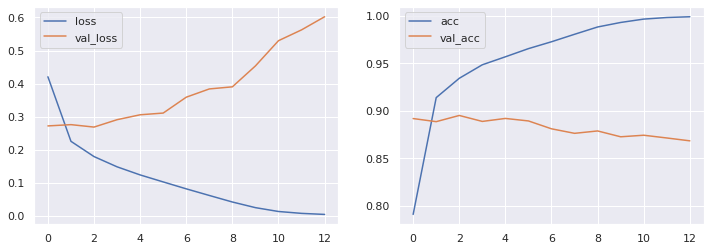

In [88]:
plot_history(history)

In [89]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8877


# Word embedding + LSTM + Conv1D

In [104]:
MAX_WORDS_PER_DOC = 400
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 400), (8000, 400), (10000, 400))

In [105]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, input_length=MAX_WORDS_PER_DOC))

model.add(keras.layers.LSTM(100, return_sequences=True))

model.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 5e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 400, 100)          80400     
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 32)           16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

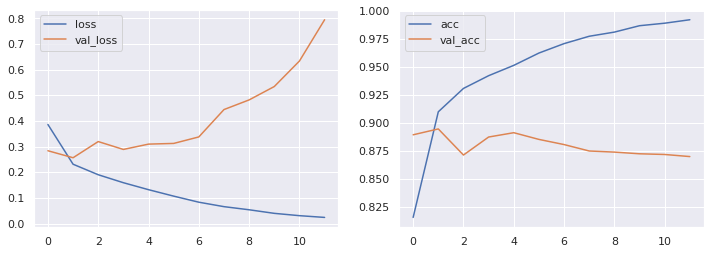

In [106]:
plot_history(history)

In [107]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8925


# Using pre-trained GloVe embedding.

Download the pre-trained word embedding from: http://nlp.stanford.edu/data/glove.6B.zip

In [110]:
def load_glove(filepath):
    embedding_index = {}
    with open(filepath) as handle:
        for line in handle:
            values = line.split()
            word = values[0]
            emb_vec = np.asarray(values[1:], dtype="float32")
            embedding_index[word] = emb_vec
    return embedding_index

In [108]:
MAX_WORDS_PER_DOC = 400
MAX_VOCAB = 20000
EMBEDDING_DIM = 100


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(reviews_train["review"].values)

word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(reviews_train["review"].values)
seq_val = tokenizer.texts_to_sequences(reviews_val["review"].values)
seq_test = tokenizer.texts_to_sequences(reviews_test["review"].values)


X_train = keras.preprocessing.sequence.pad_sequences(seq_train, MAX_WORDS_PER_DOC, padding="post")
X_val = keras.preprocessing.sequence.pad_sequences(seq_val, MAX_WORDS_PER_DOC, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(seq_test, MAX_WORDS_PER_DOC, padding="post")

X_train.shape, X_val.shape, X_test.shape

((32000, 400), (8000, 400), (10000, 400))

In [111]:
embedding_index = load_glove(os.path.join(DOWNLOAD_DIR, "glove.6B.100d.txt"))
len(embedding_index)

400000

In [119]:
# we create a matrix of one embedding for each word in the training dataset.
embedding_matrix = np.zeros((MAX_VOCAB+1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        
embedding_matrix 

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38251001,  0.14821   ,  0.60601002, ...,  0.058921  ,
         0.091112  ,  0.47283   ],
       [ 0.19915999, -0.049702  ,  0.24579   , ..., -0.068109  ,
         0.017651  ,  0.06455   ],
       ...,
       [-0.28740999, -0.015975  , -0.30695   , ..., -0.1425    ,
        -1.36629999, -0.082205  ],
       [-0.48604   , -0.92865998,  0.065223  , ..., -0.22911   ,
        -1.00549996,  0.60724002],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [121]:
keras.backend.clear_session()

model = keras.models.Sequential()

emb = keras.layers.Embedding(MAX_VOCAB+1, EMBEDDING_DIM, weights=[embedding_matrix], 
                             input_length=MAX_WORDS_PER_DOC, trainable=False)


model.add(emb)

model.add(keras.layers.LSTM(100, return_sequences=True))

model.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))

learning_rate = 5e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 400, 100)          80400     
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 32)           16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

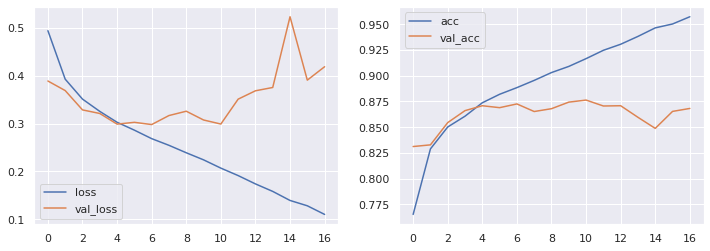

In [122]:
plot_history(history)

In [123]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8704


Make the embedding layer trainable and retrain.

In [126]:
model.layers[0].trainable = True
learning_rate = 5e-4
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 100)          2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 400, 100)          80400     
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 32)           16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

In [127]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[early_stopping_cb])

_, acc_train = model.evaluate(X_train, y_train, verbose=0)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)

print("Train acc: %0.4f" %acc_train)
print("Validation acc: %0.4f" %acc_val)

Epoch 1/100
500/500 [==============================] - 21s 41ms/step - loss: 0.2505 - acc: 0.9004 - val_loss: 0.2699 - val_acc: 0.8859
Epoch 2/100
500/500 [==============================] - 20s 40ms/step - loss: 0.2055 - acc: 0.9187 - val_loss: 0.2777 - val_acc: 0.8829
Epoch 3/100
500/500 [==============================] - 20s 41ms/step - loss: 0.1684 - acc: 0.9346 - val_loss: 0.2831 - val_acc: 0.8867
Epoch 4/100
500/500 [==============================] - 20s 40ms/step - loss: 0.1391 - acc: 0.9475 - val_loss: 0.2971 - val_acc: 0.8878
Epoch 5/100
500/500 [==============================] - 20s 40ms/step - loss: 0.1094 - acc: 0.9596 - val_loss: 0.3739 - val_acc: 0.8831
Epoch 6/100
500/500 [==============================] - 20s 40ms/step - loss: 0.0826 - acc: 0.9703 - val_loss: 0.3664 - val_acc: 0.8875
Epoch 7/100
500/500 [==============================] - 20s 40ms/step - loss: 0.0630 - acc: 0.9777 - val_loss: 0.3930 - val_acc: 0.8875
Epoch 8/100
500/500 [==============================] - 

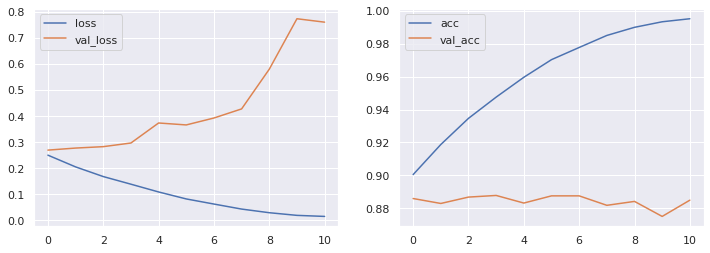

In [128]:
plot_history(history)

In [129]:
_, acc_test = model.evaluate(X_test, y_test, verbose=0)
print("Test acc: %0.4f" %acc_test)

Test acc: 0.8861
